In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config Completer.use_jedi = False        # For autocomplete to work!

In [2]:
sns.set(rc={'figure.figsize':(10,6)})
sns.set_style('whitegrid')
sns.set_palette('Set2')

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [3]:
df = pd.read_csv('data/RSCCASN.csv', parse_dates=True, index_col='DATE')

In [4]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [5]:
df.columns = ['Sales']

In [6]:
len(df)

334

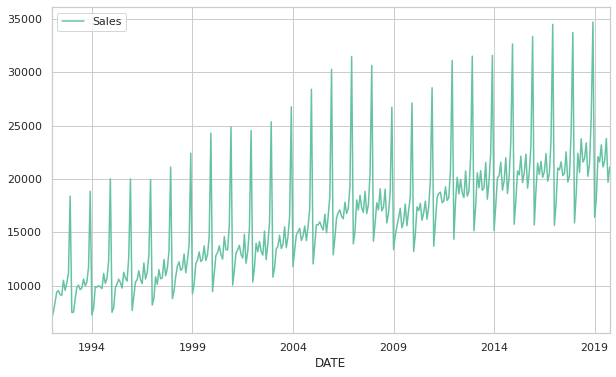

In [7]:
df.plot();

## Train Test Split
---
Monthly data! There is a clear yearly seasonality, so we can choose a test size to be 1,5 year (or 18 months).

In [8]:
len(df) - 18

316

In [9]:
test_size = 18
test_index = len(df) - test_size

In [11]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [13]:
train.tail(5)

,Sales
DATE,
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585
2018-03-01,22404
2018-04-01,20616


In [14]:
test.head(5)

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260


## Scale Data

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
scaler = MinMaxScaler()

In [20]:
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [21]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train,
                                length = length, batch_size = 1)

In [23]:
# What does the first batch look like?
X,y = generator[0]

In [24]:
len(generator)

304

In [27]:
# Just to remind me where this came from:
len(df) - test_size - length

304

In [28]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


### Create the Model

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [30]:
n_features = 1

In [31]:
model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and creating a Validation Generator

NOTE: The scaled_test dataset size MUST be greater than your length chosen for your batches.

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
early_stop = EarlyStopping(monitor='val_loss', patience = 2)

In [36]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test,
                                           length=length, batch_size=1)

In [37]:
model.fit(generator, epochs=20,
          validation_data=validation_generator,
          callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0251 - val_loss: 0.0073
Epoch 2/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0183 - val_loss: 0.0123
Epoch 3/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0124 - val_loss: 0.0072
Epoch 4/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0059 - val_loss: 8.5679e-04
Epoch 5/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 6/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss: 4.9361e-04
Epoch 7/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0023 - val_loss: 3.1118e-04
Epoch 8/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 4.0127e-04
Epoch 9/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 3.4534e-04


In [38]:
losses = pd.DataFrame(model.history.history)

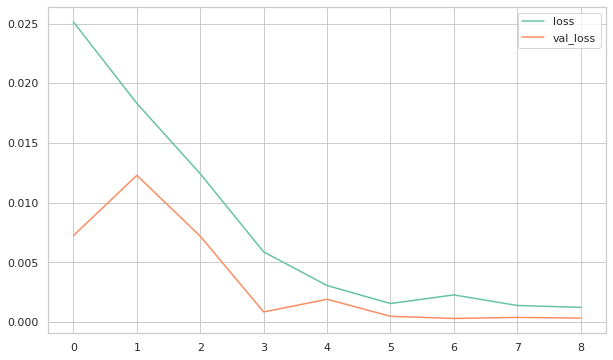

In [39]:
losses.plot();

## Evaluate on Test Data

In [40]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Inverse Transformations and Compare

In [41]:
true_predictions = scaler.inverse_transform(test_predictions)

In [42]:
test['Predictions'] = true_predictions

<ipython-input-42-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [43]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,21475.098342
2018-06-01,21589,20413.722347
2018-07-01,21919,20634.399039
2018-08-01,23381,22375.163337
2018-09-01,20260,20037.978231
2018-10-01,21473,20648.403990
2018-11-01,25831,24380.681220
2018-12-01,34706,32956.071867
2019-01-01,16410,16519.367419


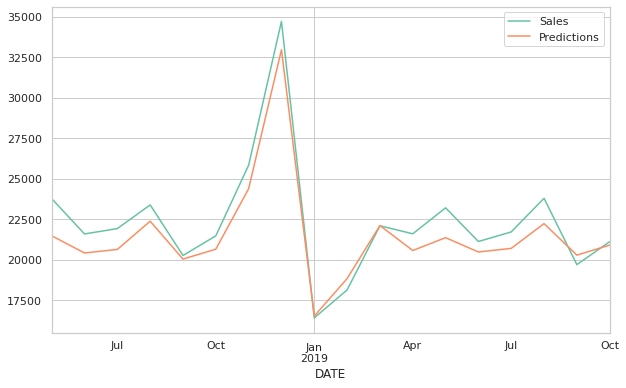

In [44]:
test.plot();

# Retrain and Forecasting

In [45]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [46]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data,
                                length = length, batch_size = 1)

In [47]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Can't use early stopping as there is no validation data for forecasting!
model.fit(generator,epochs=8)

Epoch 1/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0286
Epoch 2/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0185
Epoch 3/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0144
Epoch 4/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0081
Epoch 5/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0042
Epoch 6/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0021
Epoch 7/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0021
Epoch 8/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0016


In [48]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [49]:
forecast = full_scaler.inverse_transform(forecast)

In [50]:
forecast

array([[26396.05507183],
       [35784.2590847 ],
       [16648.01041651],
       [18768.18999887],
       [22413.94143724],
       [22069.44193316],
       [23560.63898039],
       [21682.76878071],
       [22320.50432158],
       [24175.21964741],
       [20504.61520076],
       [21982.96286535]])

### Creating new timestamp index with pandas.
---

Original df:

In [51]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [52]:
# Forecast index starts one month after the last index of df:
forecast_index = pd.date_range(start='2019-11-01', periods = periods,
                               freq= 'MS')
# freq='MS' --> MonthlyStart

In [53]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [54]:
forecast_df = pd.DataFrame(data=forecast, index = forecast_index,
                           columns=['Forecast'])

In [55]:
forecast_df

,Forecast
2019-11-01,26396.055072
2019-12-01,35784.259085
2020-01-01,16648.010417
2020-02-01,18768.189999
2020-03-01,22413.941437
2020-04-01,22069.441933
2020-05-01,23560.638980
2020-06-01,21682.768781
2020-07-01,22320.504322
2020-08-01,24175.219647


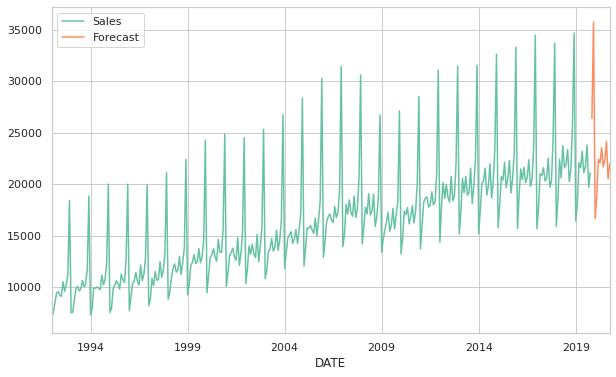

In [56]:
# Combining both plots on same ax:
ax = df.plot()
forecast_df.plot(ax=ax);

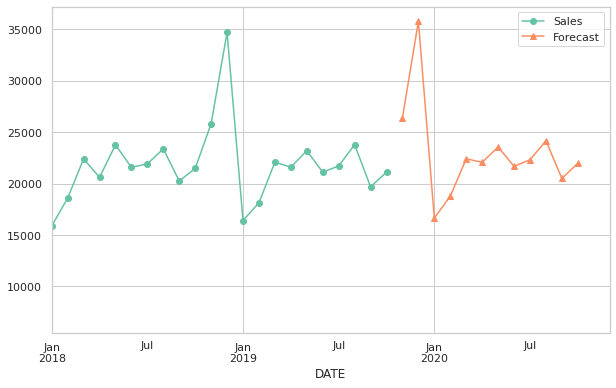

In [62]:
# Zooming in
ax = df.plot(style=['-o'])
forecast_df.plot(style=['-^'],ax=ax)
plt.xlim('2018-01-01','2020-12-01');